In [1]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
import pandas as pd
import numpy as np
import html
import re
from functools import partial
import seaborn as sbn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import scipy.stats
from pywaffle import Waffle
from sklearn.linear_model import LinearRegression
from scipy.stats import t as t_test, norm
from itertools import product
from statsmodels.api import qqplot

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Raw data preprocessing

In [139]:
header = pd.read_csv('header.csv')
data = pd.read_csv('crawled_dataset.csv')
test_data = pd.read_csv('test_data.csv')

File `header.csv` đánh dấu các cột sẽ được giữ lại (cột `alias` khác `NaN`). `Flags` quy định những thao tác xử lý chung nào cần được thực hiện trên biến này, bao gồm:
- N: String normalization (sử dụng hàm `normalize`).
- C: Categorical value (sử dụng hàm `group_singular`).
- M: Multiple value aliasing (sử dụng hàm `multi_normalize`).
- U: String with unit (sử dụng hàm `string_with_unit`).
- F: Functional processing (sử dụng hàm cùng tên với thuộc tính).

Nếu `flags` kết thúc bằng số thì giá trị đó quy định số lần tối đa một giá trị xuất hiện để được gom lại thành `other` trong hàm `group_singular`. Mặc định là 1.

In [140]:
header

,name,alias,flags
0,ASIN,NaN,NaN
1,Band Color,band_color,NC
2,Band Material,band_mat,NCM
3,Band size,band_size,NU
4,Band width,band_width,U
5,Batteries,battery,NF
6,Bezel function,bezel_func,NC
7,Bezel material,bezel_mat,NC
8,Brand Seller or Collection Name,brand,NC
9,Calendar,has_calendar,NF


In [141]:
kept_features = header.query('~alias.isna()')
preprocessed = data.drop(columns=header.query('alias.isna()')['name'], axis=1) \
                   .rename(columns={k: v for k, v in kept_features[['name', 'alias']].values})

In [142]:
test_columns_drop = test_data.columns.difference(header.query('~alias.isna()')['name'])
test_data_processed = test_data.drop(columns=test_columns_drop, axis=1, errors='ignore')\
                               .rename(columns={k: v for k, v in kept_features[['name', 'alias']].values})

In [143]:
def may_has_nan(func):
  def wrapper(st, *args, **kwargs):
    if type(st) != str:
      return st
    return func(st, *args, **kwargs)
  return wrapper

def multi_normalize(value, st):
  if type(st) != str:
    return st
  if '%' in st and value is not None:
    return value
  return st

@may_has_nan
def normalize(string):
  st = html.unescape(string.lower())
  return ' '.join(re.split('[ \-&%/]+', '%'.join(sorted(st.split('%')))))

@may_has_nan
def string_with_unit(st):
  if re.match('^([0-9]*[.])?[0-9]+$', st):
    return float(st) / 10
  match = re.match(r'(\d+(?:\.\d+)?)', st)
  if match is not None:
    u = match.span()
    v = st[u[0]:u[1]]
    unit = st[u[1]+1:]
    if unit[0] == 'm':
      return float(v) / 10
    if unit[0] == 'c':
      return float(v)
    if unit[0] != 'i':
      print(unit)
    return float(v) * 2.54
  if re.match(r'wom(a|e)n', st) is not None:
    return 17.2
  return 19

def group_singular(s, value='other', thres=1):
  t = s[s.isin(s.value_counts().where(lambda x: x <= thres).dropna().index)].values
  return s.apply(lambda x: value if x in t else x)

In [144]:
@may_has_nan
def battery(st):
  v = re.findall(r'\d ([\w ]+) batteries', st)[0]
  if v == 'unknown':
    return np.nan
  return v

@may_has_nan
def for_gender(st):
  if st.find('unisex') != -1:
    return 'unisex'
  if st.find('women') != -1:
    return 'women'
  if st.find('men') != -1:
    return 'men'
  return 'other'

@may_has_nan
def weight(st):
  v, w = st.split(' ')
  v = float(v)
  if w[0] == 'o':
    v *= 28.3495
  if w[0] == 'p':
    v *= 453.592
  if v > 500 or v < 15:
    return np.nan
  return v

@may_has_nan
def water_resist(st):
  if st.find(' ') == -1:
    return np.nan
  v, w = st.split(' ')
  v = float(v)
  if w[0] == 'f':
    v *= 0.3048
  return v

def since(st):
  return int(str(st)[:4])

@may_has_nan
def has_calendar(st):
  return st.find('no') == -1

@may_has_nan
def shape(st):
  if st != 'rectangular':
    return st
  return 'rectangle'

In [145]:
def compose(f, g):
  return lambda x: f(g(x))

def wrap(f):
  return lambda a, b: f

In [146]:
transform_d = {
  'M': wrap(lambda x: x.apply(partial(multi_normalize, 'multiple'))),
  'N': wrap(lambda x: x.apply(normalize)),
  'U': wrap(lambda x: x.apply(string_with_unit)),
  'C': lambda n, _: lambda x: group_singular(x, thres=n),
  'F': lambda _, f: lambda x: x.apply(eval(f))
}
flag_order = "MNUCF"

In [147]:
for i, val in kept_features.iterrows():
  alias = val['alias']
  flags = val['flags']
  if flags is np.nan:
    continue
  n = int(flags[-1]) if str.isdigit(flags[-1]) else 1
  transform = lambda x: x
  for flag in flag_order:
    if flag in flags:
      transform = compose(transform_d[flag](n, alias), transform)
  preprocessed[alias] = transform(preprocessed[alias])
  
preprocessed['special'] = preprocessed['special'].isnull()

In [148]:
for i, val in kept_features.iterrows():
  alias = val['alias']
  flags = val['flags']
  if flags is np.nan:
    continue
  n = int(flags[-1]) if str.isdigit(flags[-1]) else 1
  transform = lambda x: x
  for flag in flag_order:
    if flag == 'C':
      continue
    if flag in flags:
      transform = compose(transform_d[flag](n, alias), transform)
  test_data_processed[alias] = transform(test_data_processed[alias])

test_data_processed['special'] = test_data_processed['special'].isnull()

In [149]:
for col in test_data_processed.columns:
  if test_data_processed.dtypes[col] != object:
    continue
  test_data_processed[col] = test_data_processed[col].apply(lambda x: x if preprocessed[col].isin([x]).any() else 'other')

In [150]:
preprocessed = preprocessed.dropna(subset=['price'])
test_data_processed = test_data_processed.dropna(subset=['price'])

In [151]:
df_test = test_data_processed

## Dealing with missing values

In [152]:
df = preprocessed

In [160]:
nans = df.isna().sum(axis=0) + df_test.isna().sum(axis=0)

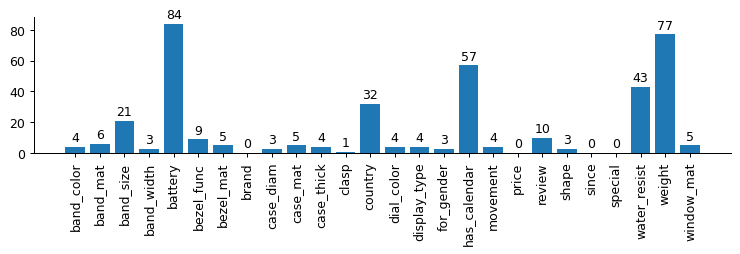

In [161]:
fig, ax = plt.subplots(figsize=(10, 2), dpi=90)
b = ax.bar(nans.index, nans)
ax.bar_label(b, padding=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
_ = plt.xticks(rotation=90)

In [60]:
df['has_calendar'] = df['has_calendar'].fillna(value=False)

In [115]:
df_test['has_calendar'] = df_test['has_calendar'].fillna(value=False)

In [62]:
def knn_imputer(df):
  headers = list(df.keys())
  df2 = df.copy()
  factorize_columns = []
  for col in df2.dtypes.keys():
    if df2.dtypes[col] == 'object':
      factorize_columns.append(col)
  labels = dict()
  category_nan = -9999
  for col in factorize_columns:
    has_nan = df2[col].isnull().sum() > 0
    df2[col], label = df2[col].factorize()
    labels[col] = label
    if has_nan:
      df2[col].replace(to_replace=-1, value=category_nan, inplace=True)

  to_fit = df2.values
  to_fit[(to_fit == category_nan)] = np.nan
  
  imputer = KNNImputer(missing_values=np.nan)
  imputer.fit(to_fit)
  new_values = imputer.transform(to_fit)
  new_values[df2.values == category_nan] = np.round(new_values[df2.values == category_nan])
  
  df_imputed = pd.DataFrame(new_values, columns=headers)
  for col in df2.columns:
    df_imputed[col] = df_imputed[col].astype(df2.dtypes[col])
  for key in labels.keys():
    df_imputed[key] = labels[key][df_imputed[key]]

  del df2
  
  return df_imputed

In [63]:
df_imputed = knn_imputer(preprocessed)

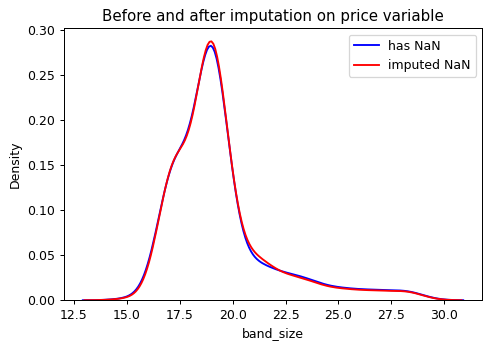

In [64]:
plt.figure(dpi=90)
sbn.kdeplot(preprocessed['band_size'], color='blue', label='has NaN')
sbn.kdeplot(df_imputed['band_size'], color='red', label='imputed NaN')
plt.title('Before and after imputation on price variable')
_ = plt.legend()

In [187]:
df = df_imputed
df_numeric = df.select_dtypes([np.int64, np.float64])

## Exploratory Data Analysis

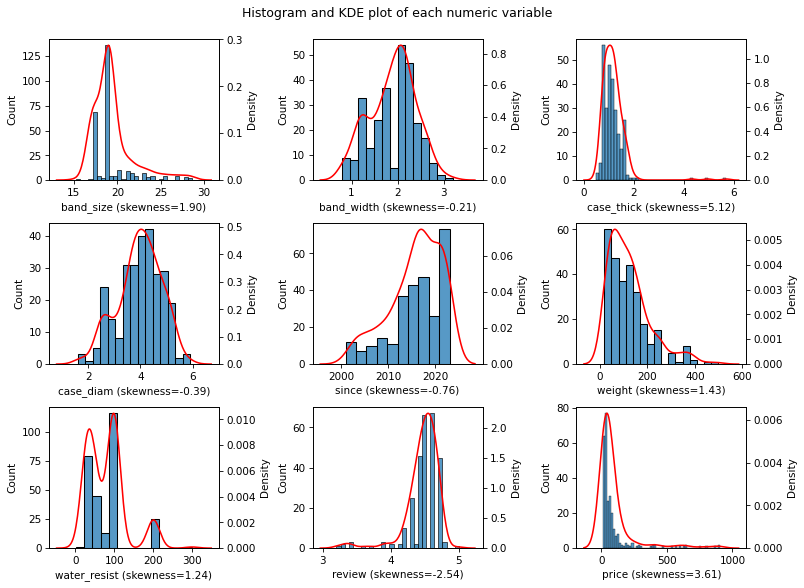

In [188]:
fig, axes = plt.subplots(3, 3, dpi=75, figsize=(12, 9))
axes[0, 1].set_title('Histogram and KDE plot of each numeric variable\n')
for c, ax in zip(df_numeric.columns, axes.flatten()):
  sbn.histplot(df_numeric[c], ax=ax)
  ax2 = ax.twinx()
  sbn.kdeplot(df_numeric[c], ax=ax2, color='red')
  ax.set_xlabel(c + f" (skewness={df[c].skew():.2f})")
plt.subplots_adjust(wspace=0.55, hspace=0.3)

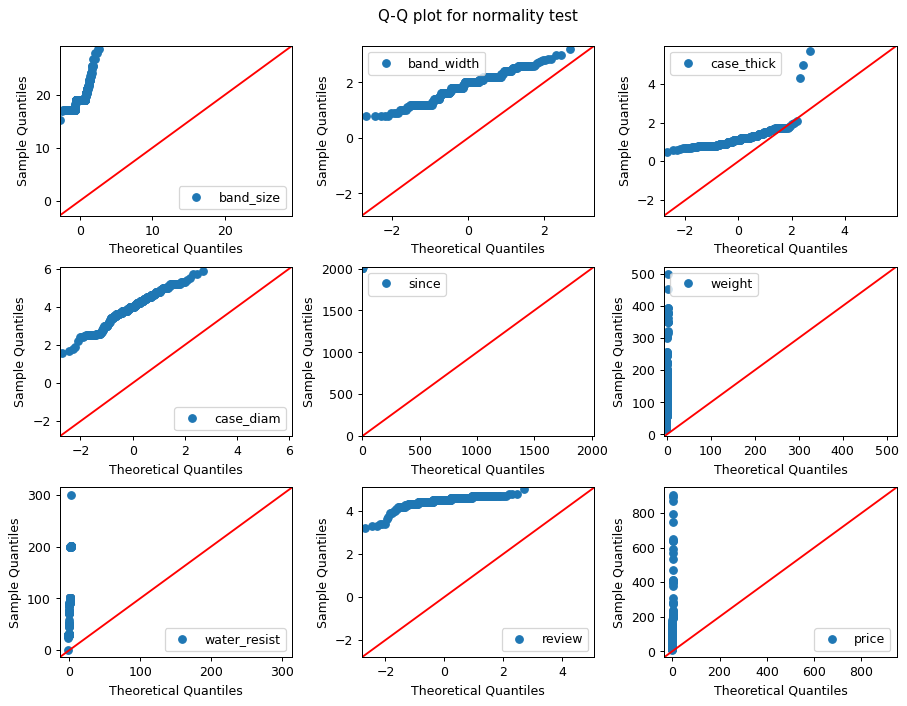

In [225]:
fig, axes = plt.subplots(3, 3, dpi=90, figsize=(12, 9))
axes[0, 1].set_title('Q-Q plot for normality test\n')
for c, ax in zip(df_numeric.columns, axes.flatten()):
  qqplot(df[c], ax=ax, line='45', label=c)
  ax.legend()
plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [190]:
# Anderson-Darling test for normality
print('Null hypothesis: The samples of a variable follows a normal distribution\n')

for c, i in zip(df_numeric.columns, range(9)):
  res = scipy.stats.anderson(df_numeric[c], dist='norm')
  rejected = res.statistic >= res.critical_values[-2]
  print(c + ": H0 " + ("" if rejected else "not ") + "rejected")

Null hypothesis: The samples of a variable follows a normal distribution

band_size: H0 rejected
band_width: H0 rejected
case_thick: H0 rejected
case_diam: H0 rejected
since: H0 rejected
weight: H0 rejected
water_resist: H0 rejected
review: H0 rejected
price: H0 rejected


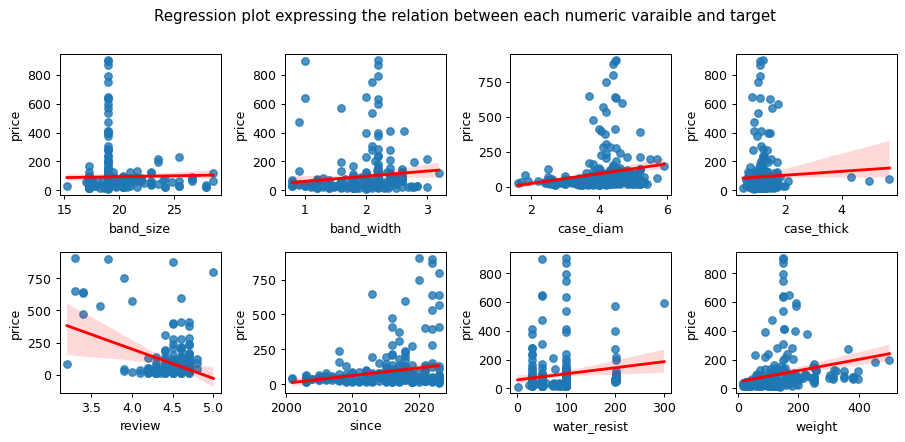

In [191]:
fig, axes = plt.subplots(2, 4, dpi=90, figsize=(12, 5))
for c, ax in zip(df_numeric.columns.difference(['price']), axes.flatten()):
  sbn.regplot(data=df_numeric, x=c, y='price', ax=ax, line_kws={"color": "red"})
plt.subplots_adjust(wspace=0.4, hspace=0.4)
_ = fig.suptitle('Regression plot expressing the relation between each numeric varaible and target')

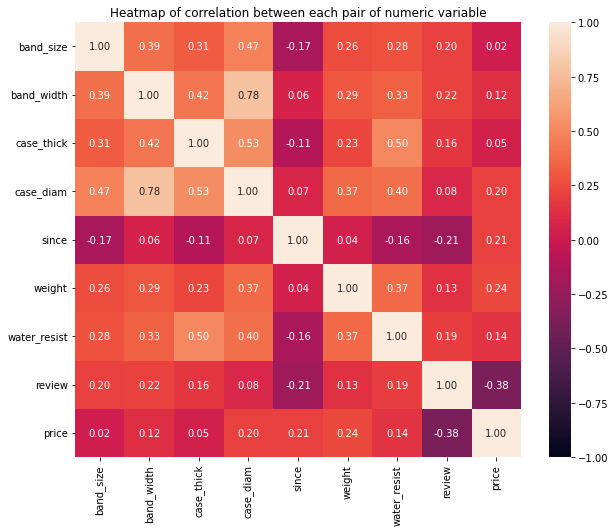

In [192]:
plt.figure(figsize=(10, 8))
sbn.heatmap(df_numeric.corr(), fmt='.2f', annot=True, vmin=-1, vmax=1)
_ = plt.title('Heatmap of correlation between each pair of numeric variable')

In [193]:
categorical_columns = df.select_dtypes(['object', bool]).columns

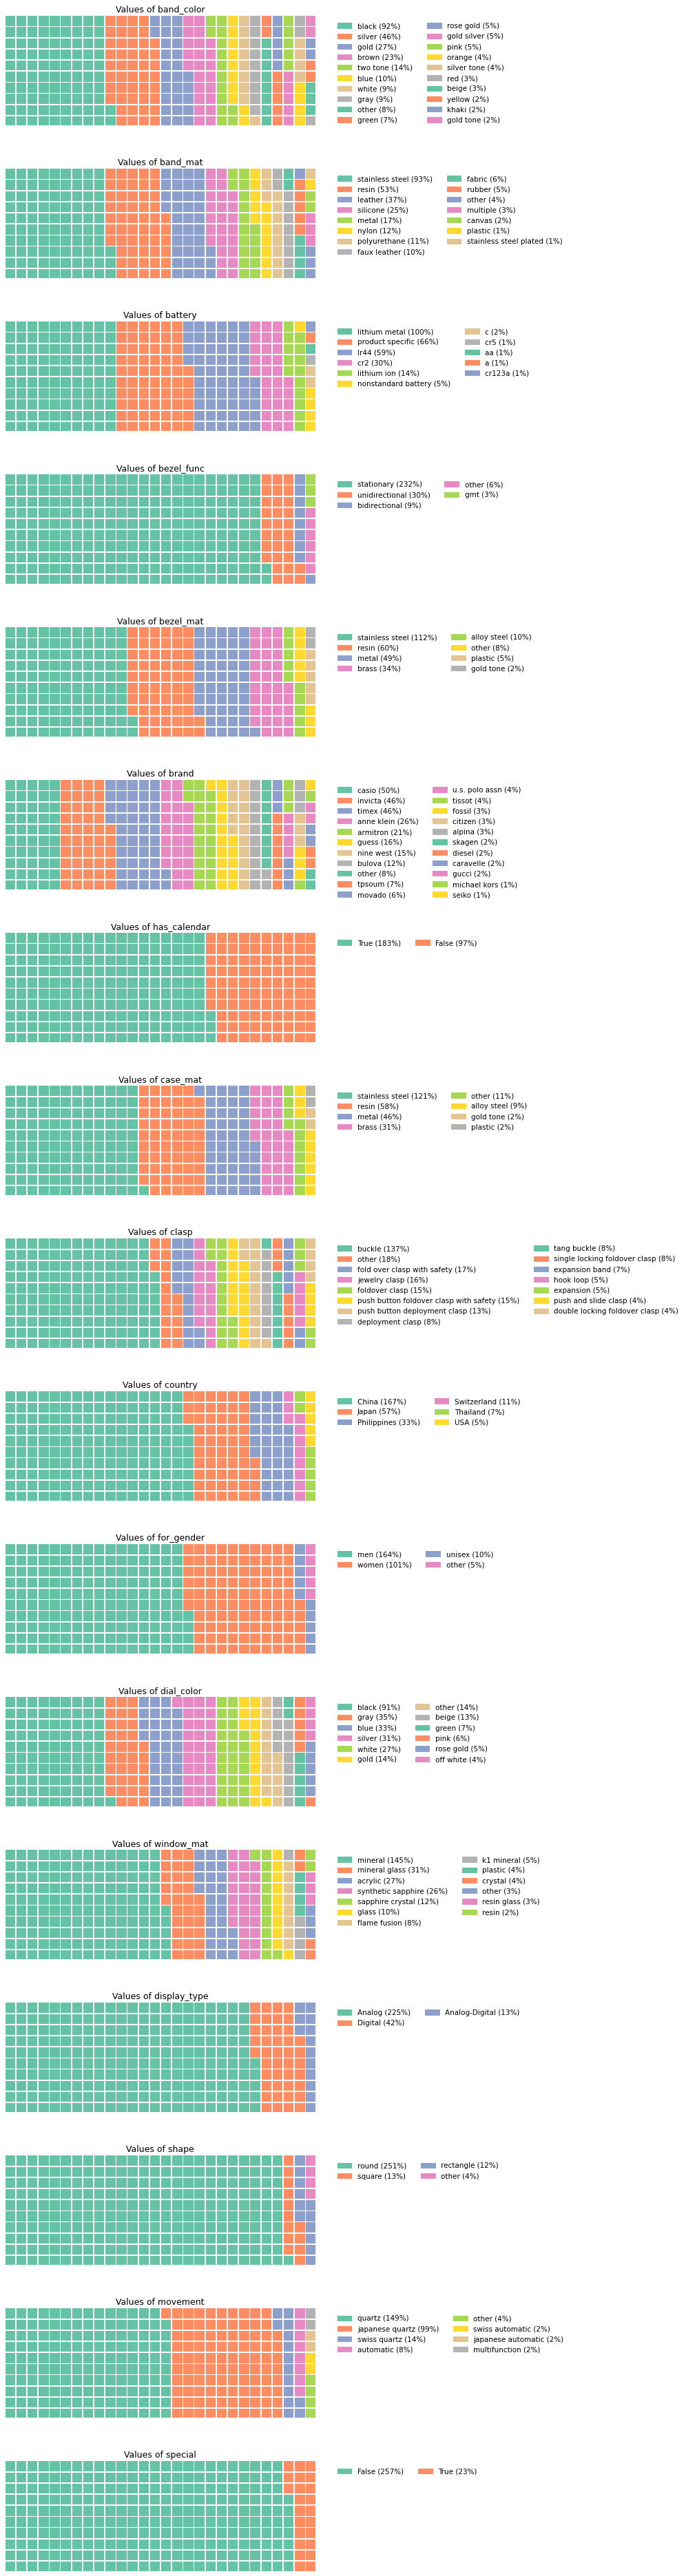

In [26]:
plots = dict()
for i, c in enumerate(categorical_columns):
  d = df[c].value_counts()
  
  plots[(17, 1, i+1)] = {
    'values': d,
    'title': {'label': "Values of " + c},
    'labels': ["{0} ({1}%)".format(k, v) for k, v in d.items()],
    'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'ncol': 2, 'framealpha': 0}
  }
  
fig = plt.figure(
  FigureClass=Waffle,
  plots=plots,
  rows=10,
  figsize=(15, 50),
  dpi=75
)

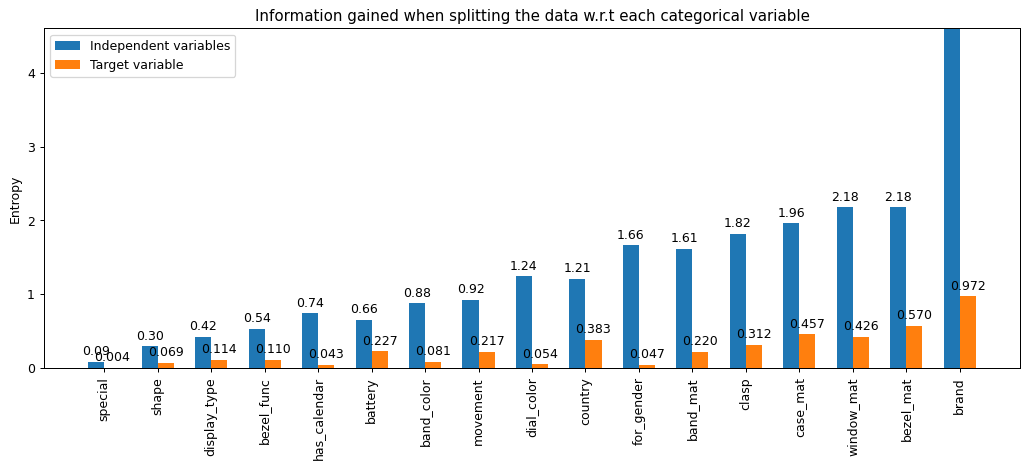

In [194]:
fig, ax = plt.subplots(dpi=90, figsize=(14, 5))
ax.set_title('Information gained when splitting the data w.r.t each categorical variable')
bar_title = []
bar_v1 = []
bar_v2 = []
for c in categorical_columns:
  ig = mutual_info_classif(df_numeric, df[c])
  bar_title.append(c)
  bar_v1.append(ig[:-1].sum())
  bar_v2.append(ig[-1])
  
x = np.arange(len(categorical_columns))
w = 0.3

bar_v1 = np.array(bar_v1)
bar_v2 = np.array(bar_v2)
bar_title = np.array(bar_title)

order = np.argsort(bar_v1 + bar_v2)

b1 = ax.bar(x=x, height=bar_v1[order], width=w, label='Independent variables')
ax.bar_label(b1, padding=3, fmt='%.2f')
b2 = ax.bar(x=(x+w), height=bar_v2[order], width=w, label='Target variable')
ax.bar_label(b2, padding=3, fmt='%.3f')

ax.legend()
ax.set_ylim([0, 4.6])
ax.set_xticks(x + w/2)
ax.set_xticklabels(bar_title[order])
ax.set_ylabel('Entropy')
_ = plt.xticks(rotation=90)

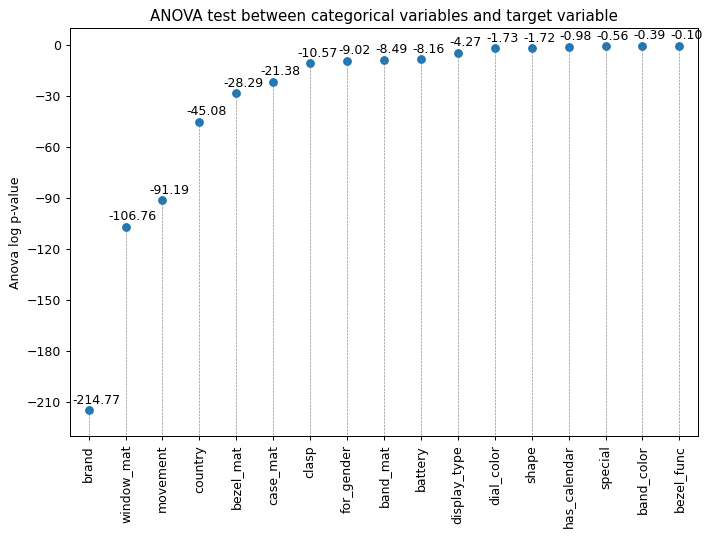

In [224]:
# ANOVA test between categorical variables and target variable
for c in categorical_columns:
  groups = df[[c, 'price']].groupby(c)
  unique = df[c].unique()
  anova_res = scipy.stats.f_oneway(*[groups.get_group(v)['price'] for v in unique])
  
fig, ax = plt.subplots(dpi=90, figsize=(9, 6))
ax.set_title('ANOVA test between categorical variables and target variable')
titles = []
p_values = []
for c in categorical_columns:
  groups = df[[c, 'price']].groupby(c)
  unique = df[c].unique()
  anova_res = scipy.stats.f_oneway(*[groups.get_group(v)['price'] for v in unique])
  titles.append(c)
  p_values.append(np.log(anova_res.pvalue))
  
p_values = np.array(p_values)
titles = np.array(titles)
  
args = np.argsort(p_values)
xs = np.arange(len(categorical_columns))
ax.scatter(xs, p_values[args])

for x, p in zip(xs, p_values[args]):
  points_x = [x, x]
  points_y = [p, -250]
  ax.plot(points_x, points_y, ls='--', color='gray', lw=0.5)
  ax.text(x+0.2, p+4, f'{p:.2f}', horizontalalignment='center')

ax.set_xticks(xs)
ax.set_xticklabels(titles[args])
ax.set_ylabel('Anova log p-value')
ax.set_xlim([-0.5, xs[-1]+0.5])
ax.set_ylim(-230, 10)
ax.set_yticks(np.arange(-210, 10, 30))
# ax.set_yscale('log')
_ = plt.xticks(rotation=90)

## Model

In [25]:
canb_dropped = ['special', 'bezel_func', 'has_calendar', 'shape', 'dial_color', 'band_color']

#### Helper functions

In [26]:
def train_test_split(df):
  df_train = df.iloc[preprocessed.query('~price.isna()').index]
  df_test = df.iloc[preprocessed.query('price.isna()').index]
  return df_train, df_test

def xy_split(df):
  return df.drop(columns=['price'], axis=1), df['price']

def init(df):
  df2 = df.drop(columns=['price'], axis=1)
  df_categoric = df2.select_dtypes(['object', bool])
  nbest = NaiveBayesEstimator(df_categoric)
  knnest = KNNExtrapolate(df2)
  return nbest, knnest

In [43]:
def t_alpha(alpha, df):
  return t_test.interval(1-alpha, df)[1]

zip_with = lambda f, u, v: [f(ui, vi) for (ui, vi) in zip(u, v)]

def combine_normal_distribution(cfi, alpha=0.05, sampling_rate=50, start=-1000, stop=2000):
  phi = norm.ppf(1-alpha/2)
  steps = sampling_rate * (stop - start)
  samples = np.zeros(steps)
  xs = np.linspace(start, stop, steps + 1)[:-1]
  for p, (l, r) in cfi:
    mu = (l + r) / 2
    if (r - l) < 2:
      l = mu-1
      r = mu+1
    std = (mu - l) / phi
    samples += p * np.exp(-((xs - mu)/std)**2 / 2) / np.sqrt(2*np.pi) / std
  
  cdf = np.cumsum(samples)
  cdf /= cdf.max()
  lowb = np.where(cdf > alpha/2)[0]
  if len(lowb) == 0:
    print(cdf,samples)
    return l, (l, r)
  low = lowb[0] / sampling_rate + start
  high = np.where(cdf < 1-alpha/2)[0][-1] / sampling_rate + start
  return (low + high) / 2, (low, high)

def distance_to_weight(dist, temp=1):
  zeros = (dist == 0)
  if zeros.sum() > 0:
    return zeros.astype(int) / zeros.sum()
  
  expinvdist = np.exp(1/dist * 1/temp)
  return expinvdist / expinvdist.sum()

def distance_to_weight(dist, temp=1):
  zeros = (dist == 0)
  if zeros.sum() > 0:
    return zeros.astype(int) / zeros.sum()
  
  expinvdist = np.exp(1/dist * 1/temp)
  return expinvdist / expinvdist.sum()

In [28]:
precompute = np.array([norm.ppf(1-i/2) for i in [2-0.01, 2-0.05, 2-0.15, 1, 0.15, 0.05, 0.01]])
x_label = [0, 12, 22, 50, 100-22, 100-12, 100]
ct = ['1%', '5%', '15%', '50%', '85%', '95%', '99%']

def plot_normal(cfi):
  fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
  ax.plot([0, 100], [0, 0], color='black')
  ax.scatter(x_label, np.zeros(7), marker='|', color='black', \
            s=np.array([5, 10, 15, 25, 15, 10, 5])*10)
  m = (cfi[0] + cfi[1]) / 2
  s = (m - cfi[0]) / precompute[-1]

  for v, (x, c) in zip(precompute * s + m, zip(x_label, ct)):
    ax.text(x, 0.012, f"{v:.2f}", horizontalalignment='center')
    ax.text(x, -0.02, c, horizontalalignment='center')
  
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.set_title('Confident interval')

#### Model classes

In [29]:
class NaiveBayesEstimator:
  def __init__(self, df_categoric):
    self.data = df_categoric.values
    self.masks = dict()
    self.uniques = []
    for i in range(self.data.shape[1]):
      self.uniques.append(np.unique(self.data[:, i]))
      for val in self.uniques[-1]:
        self.masks[(i, val)] = self.data[:, i] == val
    self.cat_key = list(df_categoric.columns)
        
    
  def predict(self, **kwargs):
    out = [[] for i in range(len(self.cat_key))]
    mask = []
    
    for k in kwargs.keys():
      if k not in self.cat_key:
        print(f"Unknown variable `{k}`")
        continue
      if kwargs[k] is None:
        continue
      i = self.cat_key.index(k)
        
      if kwargs[k] not in self.data[:, i]:
        print(f"Unknown value '{kwargs[k]}' for variable `{k}`")
        continue
      out[i].append((1., kwargs[k]))
      mask.append(self.data[:, i] == kwargs[k])
      
    unknown = [i for i in range(len(self.cat_key)) if len(out[i]) == 0]
      
    for id in unknown:
      unique_val = self.uniques[id]
      # P[val|known] ~ prod P[known_i|val]
      prob = []
      for val in unique_val:
        b = self.masks[(id, val)]
        p = 1
        for m in mask:
          p *= (m & b).sum() / b.sum()
        prob.append(p)
      if np.sum(prob) < 1e-5:
        prob = np.ones_like(prob)
      prob = np.array(prob) / np.sum(prob)
      
      for p, v in zip(prob, unique_val):
        if p < 1e-4:
          continue
        out[id].append((p, v))
        
    return out

In [30]:
class KNNExtrapolate:
  def __init__(self, df):
    self.data = df.select_dtypes(['object', bool])
    self.mapper = dict()
    for col in self.data.columns:
      self.data[col], mapper = self.data[col].factorize()
      self.mapper[col] = list(mapper)
      
    self.columns = list(self.data.columns)
    self.data = self.data.values
    num = df.select_dtypes([np.float64, np.int64])
    self.numeric = num.values
    self.numeric_key = list(num.columns)
    self.numeric_dtypes = num.dtypes
    
  def nearest_neighbors(self, key, top_k):
    similarity = ((self.data - key) != 0).sum(axis=1)
    argmins = np.argsort(similarity)[:top_k]
    return argmins, similarity[argmins]
  
  def predict(self, top_k=10, entropy_boost=1, **params):
    key = [-1] * len(self.columns)
    val_known = [None] * len(self.numeric_key)
    for k, v in params.items():
      if k not in self.columns and k not in self.numeric_key:
        print("Unrecognized categorical variable", k)
        continue
      if v is None:
        continue
      if k in self.numeric_key:
        val_known[self.numeric_key.index(k)] = v
        continue
      if v not in self.mapper[k]:
        print("Unrecognized value", v, "for variable", k)
        continue
      key[self.columns.index(k)] = self.mapper[k].index(v)
    
    if any(map(lambda x: x == -1, key)):
      print(key)
      print("Missing some categorical variables, use Naive Bayes Estimator first")
      return None
    
    key = np.array(key).reshape((1, -1))
    
    argmins, distances = self.nearest_neighbors(key, 10)
    val_pred = (self.numeric[argmins] * distance_to_weight(distances, entropy_boost).reshape((-1, 1))).sum(axis=0)
    val_out = [v2 if v1 is None else v1 for v1, v2 in zip(val_known, val_pred)]
    for i, v in enumerate(self.numeric_key):
      if self.numeric_dtypes[v] == np.int64:
        val_out[i] = np.round(val_out[i])
    return val_out

In [42]:
class TreeNode:
  def __init__(self, categories, values, target, exclude=[], root_coefficient=None):
    self.categories = categories
    self.values = values
    self.target = target
    self.var_target = self.target.std() ** 2
    self.exclude = exclude
    self.children = []
    self.children_weight = []
    self.best_id = None
    self.best_score = None
    self.model = LinearRegression()
    self.model.fit(values, target)
    self.score = self.model.score(values, target)
    self.parent = None
    self.child_id = 0
    self.root_coefficient = root_coefficient if root_coefficient is not None else 1/self.var_target
    self.cat_value = None
    u = np.concatenate([np.ones((self.values.shape[0], 1)), self.values], axis=1)
    self.design = np.linalg.pinv(u.T @ u)
    
  @property
  def mse(self):
    return (1 - self.score) * self.var_target
    
  def __split(self, cat_id):
    col = self.categories[:, cat_id]
    val, counts = np.unique(col, return_counts=True)
    if any(counts == 1):
      return 0
    weights = counts / len(col)
    mse = 0
    for v, w in zip(val, weights):
      leaf = TreeNode(self.categories, self.values[col == v], self.target[col == v], root_coefficient=1)
      mse += leaf.mse*w
      del leaf
    return 1 - mse/self.var_target
  
  def split_test(self):
    if self.best_id is not None:
      return (self.best_score - self.score) * self.root_coefficient
    best_score = 0
    best_id = None
    for i in range(self.categories.shape[1]):
      if i in self.exclude:
        continue
      score = self.__split(i)
      if score > best_score:
        best_id = i
        best_score = score
    
    if best_id is None or best_score < self.score:
      return 0
    self.best_id = best_id
    self.best_score = best_score
    mse_best = (1 - best_score)*self.var_target
    return (self.mse - mse_best) * self.root_coefficient
    
  def split(self):
    best_id = self.best_id
    col = self.categories[:, best_id]
    val, counts = np.unique(col, return_counts=True)
    weights = counts / len(col)
    for i, (v, w) in enumerate(zip(val, weights)):
      b = col == v
      child = TreeNode(self.categories[b], self.values[b], self.target[b], self.exclude + [best_id], \
                       self.root_coefficient * w)
      child.child_id = i
      child.parent = self
      child.cat_value = v
      self.children.append(child)
      self.children_weight.append(w)
    
    mse_best = (1 - self.best_score)*self.var_target
    delta_mse = self.mse - mse_best
    self.score = self.best_score
    p = self.parent
    c = self
    while p is not None:
      w = p.children_weight[c.child_id]
      delta_score = delta_mse * w / p.var_target
      mse_old = p.mse
      p.score += delta_score
      mse_new = p.mse
      
      delta_mse = mse_old - mse_new
      c = p
      p = c.parent
    return self.children
  
  def confidence_interval(self, x, alpha=0.05):
    x_t = np.concatenate([np.ones(1), x])[None, :]
    n = len(self.target)
    return np.squeeze(t_alpha(alpha, n-1) * np.sqrt((self.mse * n) / (n-1) * (1 + x_t @ self.design @ x_t.T)))

In [32]:
class DTwithLR:
  def __init__(self, df, price):
    cat = df.select_dtypes(['object', bool])
    num = df.select_dtypes([np.float64, np.int64])
    self.categories = cat.values
    self.values = num.values.astype(np.float32)
    self.target = price.values
    self.root = TreeNode(self.categories, self.values, self.target)
    self.frontiers = [self.root]
    self.do_matters = []
    self.cat_key = cat.columns
    self.val_key = num.columns

  def expand(self):
    best = None
    best_val = 0
    for node in self.frontiers:
      increment = node.split_test()
      # print(increment)
      if increment > best_val:
        best_val = increment
        best = node
        
    self.frontiers.remove(best)
    self.do_matters.append(best.best_id)
    
    new_nodes = best.split()
    self.frontiers.extend(new_nodes)
    return best_val

  def fit(self, expansions=3):
    for i in range(expansions):
      self.expand()
    return np.sqrt(self.root.mse), self.root.score
  
  def compile_tree(self):
    return self.root.to_dict()
  
  def predict_single(self, attrs, vals, confidence=False, df=False):
    c = self.root
    while len(c.children) > 0:
      i = c.best_id
      cat_v = attrs[i]
      for child in c.children:
        if child.cat_value == cat_v:
          c = child
          break
      else:
        break
    y_h = c.model.predict(np.array([vals]))[0]
    if not confidence:
      return y_h
    
    inv = c.confidence_interval(vals)
    if df:
      return (y_h - inv, y_h + inv), len(c.target) - 1
    return (y_h - inv, y_h + inv)
  
  def predict_df(self, x_df):
    cat = x_df.select_dtypes(['object']).values
    val = x_df.select_dtypes([np.float64, np.int64]).values.astype(np.float32)
    return np.array(zip_with(self.predict_single, cat, val))
  
  def evaluate(self, x_df, target):
    pred = self.predict_df(x_df)
    
    mse = np.mean((pred - target)**2)
    r2 = 1 - mse / target.std() ** 2
    return mse, r2
  
  def prediction_with_nb(self, attrs, vals, top_k=10, entropy_boost=1):
    placeholder = []
    params = dict()
    
    for i, attr in enumerate(attrs):
      if i not in self.do_matters:
        params[self.cat_key[i]] = attr[0][-1]
      else:
        params[self.cat_key[i]] = None
      placeholder.append(params[self.cat_key[i]])
    
    board = [attrs[i] for i in self.do_matters]
    iters = product(*board)
    intervals = []
    
    for item in iters:
      prob = 1
      for id, v in zip(self.do_matters, item):
        params[self.cat_key[id]] = placeholder[id] = v[1]
        prob *= v[0]

      if any(map(lambda x: x is None, vals)):
        for v, k in zip(vals, self.val_key):
          params[k] = v
        vals = knnest.predict(top_k, entropy_boost, **params)
      
      l, h = self.predict_single(placeholder, vals, confidence=True)
      
      for interval in intervals:
        u, v = interval[1]
        if (u-l)*(u-l) + (v-h)*(v-h) < 1e-3:
          interval[0] += prob
          break
      else:
        intervals.append([prob, (l, h)])
    return intervals

  def predict(self, top_k=10, entropy_boost=1, **d_args):
    categorical = dict()
    values = []
    
    for k in self.cat_key:
      categorical[k] = d_args[k] if k in d_args else None
    for k in self.val_key:
      values.append(d_args[k] if k in d_args else None)

    attrs = nbest.predict(**categorical)
    return combine_normal_distribution(self.prediction_with_nb(attrs, values, \
                                                               top_k=top_k, entropy_boost=entropy_boost, ))

#### Code

In [66]:
df = df.drop(columns=canb_dropped, axis=1)

In [67]:
nbest, knnest = init(df)

In [68]:
df_train, price = xy_split(df)

In [69]:
model = DTwithLR(df_train, price)
model.fit(expansions=2)

(45.529300113185116, 0.9036498589083484)

In [229]:
def test(model, df):
  print(f"Test set cardiality: {len(df)}")
  se = []
  ys = []
  for i, v in df.iterrows():
    y = v['price']
    x = v.drop('price').dropna().to_dict()
    m, cfi = model.predict(**x)
    se.append((y - m) ** 2)
    ys.append(y)

  ys = np.array(ys)
  se = np.array(se)
  mse = se.sum() / len(ys)
  r2 = 1 - se.sum() / np.power(ys - ys.mean(), 2).sum()
  print(f"Root mean squared error: {np.sqrt(mse):.3f}; R2-score: {r2:.3f}")
  return np.sqrt(mse), r2

In [230]:
test(model, df_test)

Test set cardiality: 20
Root mean squared error: 33.677; R2-score: 0.702


(33.67735982822882, 0.7017412569134351)

In [253]:
test(model, df.sample(10))

Test set cardiality: 10
Root mean squared error: 43.836; R2-score: 0.218


(43.835805684394586, 0.21792141165652512)

[Example 1](https://www.amazon.com/GUESS-Stainless-Gunmetal-Chronograph-Bracelet/dp/B00V49K740/ref=sr_1_17?crid=1F6X3EFIGPXBJ&keywords=watches%2Bfor%2Bmen&qid=1701960719&sprefix=watch%2Caps%2C684&sr=8-17&th=1)

In [122]:
t = {
 'band_mat': 'stainless steel',
 'band_width': 2.2,
 'band_size': 19,
 'battery': 'product specific',
 'bezel_mat': 'stainless steel',
 'brand': 'guess',
 'case_thick': 1.2,
 'case_diam': 4.45,
 'case_mat': 'stainless steel',
 'clasp': 'deployment clasp',
 'country': 'China',
 'since': 2015,
 'for_gender': 'men',
 'window_mat': 'mineral',
 'display_type': 'Analog',
 'weight': 172.932,
 'movement': 'quartz',
 'water_resist': 50.2,
 'review': 4.6,
 # 'price': 175,
}

In [123]:
model.predict(**t)

(114.26000000000005, (-43.120000000000005, 271.6400000000001))

[Example 2](https://www.amazon.com/Casio-GA100-1A1-Watch-Model/dp/B003WPUU0U/ref=sr_1_6?crid=1M1KPE0NVJMF2&keywords=watches%2Bfor%2Bmen&qid=1702201251&sprefix=watches%2Bfor%2Bmen%2Caps%2C291&sr=8-6)

In [124]:
t = {
 'band_mat': 'rubber',
 'band_width': 1.8,
 'band_size': 19,
 'battery': 'lithium metal',
 'bezel_mat': 'stainless steel',
 'brand': 'casio',
 'case_thick': 1.7,
 'case_diam': 5.1,
 'case_mat': 'resin',
 'clasp': 'buckle',
 'country': 'China',
 'since': 2010,
 'for_gender': 'men',
 'window_mat': 'mineral',
 'display_type': 'Digital',
 'weight': 70.87,
 'movement': 'quartz',
 'water_resist': 200,
 'review': 4.7,
 # 'price': 99,
}

In [125]:
model.predict(**t)

(169.80999999999995, (-6.960000000000036, 346.5799999999999))

## Interactive widgets

In [126]:
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets

In [127]:
def dropdown_hbox(name, options):
  return widgets.Dropdown(
    options=options,
    values=options[0],
    description=name + ":",
    disabled=False,
    style={'description_width': '100px'},
    layout = widgets.Layout(width='300px')
  )

def numeric(widget, name, min=None, max=None, init=None):
  return widget(
    value=init if init is not None else 0,
    description=c + ":",
    disabled=False,
    style=style,
    min=min if min is not None else 0,
    max=max,
    layout = widgets.Layout(width='300px')
  )

In [128]:
def wrapbox(widget):
  c = widgets.Checkbox(
    value=False,
    disabled=False,
    description='Empty',
    indent=False,
    layout = widgets.Layout(width='100px')
  )
  widgets.jslink((widget, 'disabled'), (c, 'value'))
  return widgets.HBox([widget, c]), c

In [129]:
w = dict()
widget_list_1 = []
widget_list_2 = []
style = {'description_width': '100px'}
for c in df.columns.difference(['price']):
  target = None
  if df.dtypes[c] == object or df.dtypes[c] == bool:
    target = widget_list_1
  else:
    target = widget_list_2

  wgt = None
  if df.dtypes[c] == object or df.dtypes[c] == bool:
    wgt = dropdown_hbox(c, df[c].unique())
  elif df.dtypes[c] == np.int64:
    wgt = numeric(widgets.BoundedIntText, c, df[c].min(), df[c].max(), df[c].max())
  else:
    wgt = numeric(widgets.FloatText, c)

  box, chb = wrapbox(wgt)
  target.append(box)
  w[c] = wgt
  w[c + '_empty'] = chb

In [130]:
widget_left = widgets.VBox(widget_list_1)
widget_right = widgets.VBox(widget_list_2)
widget = widgets.HBox([widget_left, widget_right])

In [131]:
def process(**inputs):
  t = dict()
  for key in inputs.keys():
    if key.endswith('_empty'):
      if inputs[key] == True:
        t[key[:-6]] = None
    else:
      if key not in t:
        t[key] = inputs[key]

  params = dict()
  for k in t.keys():
    if t[k] is not None:
      params[k] = t[k]

  mean, cfi = model.predict(**params)
  print(mean, cfi)

In [132]:
out = interactive_output(process, w)

In [133]:
display(widget, out)

Output(outputs=({'name': 'stdout', 'text': '262.69000000000005 (261.70000000000005, 263.68000000000006)\n', 'o…